In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [3]:
data_dir = '/mnt/data/nexar'
ckpt_path = './models/finetuned/faster_rcnn_resnet101_nexar'
labels_path = './nexar_label_map.pbtxt'
num_classes = 5
image_dir = os.path.join(data_dir, 'images')
annotations = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_boxes = pd.read_csv(os.path.join(data_dir, 'train_boxes.csv'))

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(ckpt_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [5]:
examples_list = list(annotations['image_filename'])

# use the same split as in training
random.seed(42)
random.shuffle(examples_list)
num_examples = len(examples_list)
num_train = int(0.7 * num_examples)
train_examples = examples_list[:num_train]
val_examples = examples_list[num_train:]

In [6]:
label_map = label_map_util.load_labelmap(labels_path)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [8]:
!nvidia-smi

Tue Sep  5 11:54:25 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 378.13                 Driver Version: 378.13                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Graphics Device     Off  | 0000:01:00.0     Off |                  N/A |
| 28%   52C    P2    62W / 250W |   4306MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Graphics Device     Off  | 0000:02:00.0     Off |                  N/A |
| 23%   40C    P8    17W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

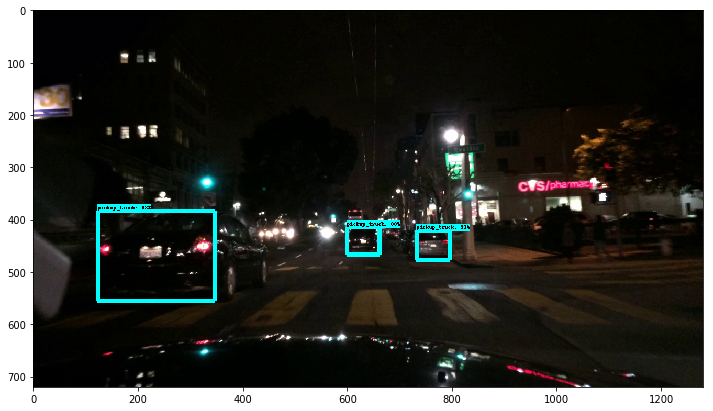

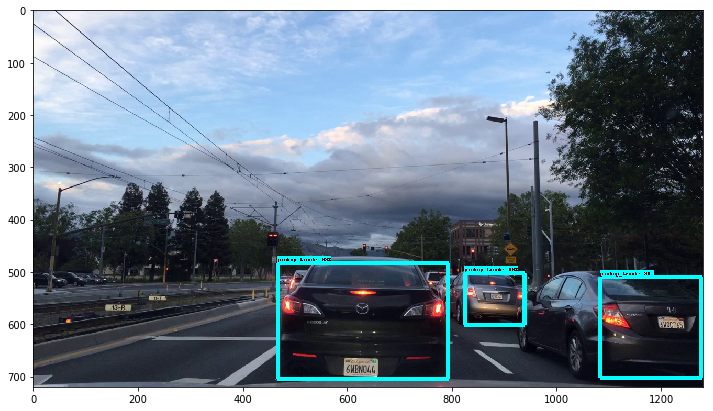

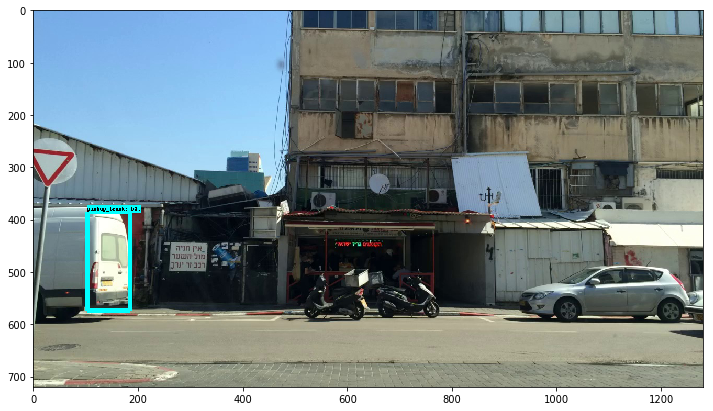

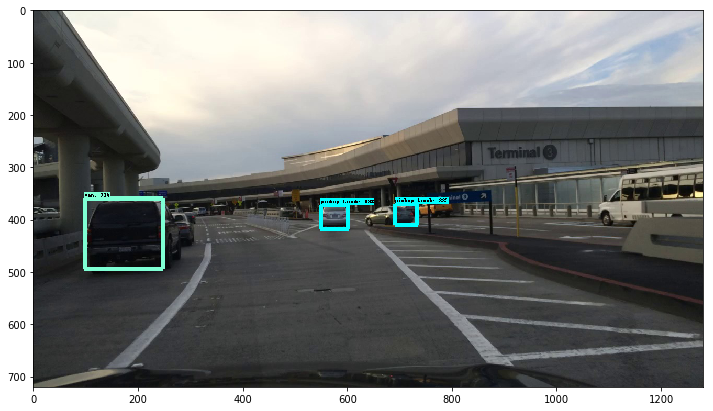

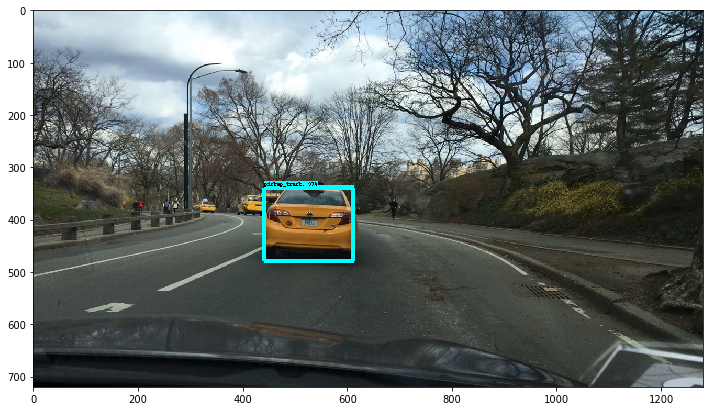

In [10]:
IMAGE_SIZE = (12, 8)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in val_examples[:5]:
            image = Image.open(os.path.join(image_dir, image_path))
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8,
                min_score_thresh=.5)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

## Following code taken from @bendyna baseline https://github.com/bendyna/nexar-baseline/blob/master/nexar-baseline.ipynb

In [10]:
def get_predictions(image_filenames):
    result = []
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            for image_path in tqdm(image_filenames):
                image = Image.open(os.path.join(image_dir, image_path))
                w, h = image.width, image.height
                image_np = load_image_into_numpy_array(image)
                image_np_expanded = np.expand_dims(image_np, axis=0)
                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                scores = detection_graph.get_tensor_by_name('detection_scores:0')
                classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                (boxes, scores, classes, num_detections) = sess.run(
                    [boxes, scores, classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
                out_boxes, out_scores, out_classes = boxes[0], scores[0], classes[0]

                prediction_boxes = []
                for i in range(len(out_boxes)):
                    box = (out_boxes[i][1], out_boxes[i][0], out_boxes[i][3], out_boxes[i][2])
                    prediction_boxes.append((out_scores[i], box))
                true_boxes = []
                for _, row in train_boxes[train_boxes.image_filename == image_path].iterrows():
                    true_boxes.append((row.x0 / w, row.y0 / h, row.x1 / w, row.y1 / h))
                result.append((image_path, true_boxes, prediction_boxes))
    return result

In [11]:
# box - (xmin, ymin, xmax, ymax)
def IOU(box1, box2):
    left = max(box1[0], box2[0])
    top = max(box1[1], box2[1])
    right = min(box1[2], box2[2])
    bottom = min(box1[3], box2[3])
    w = max(0, right - left + 1)
    h = max(0, bottom - top + 1)
    inter = w * h
    uni = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1) \
            + (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1) - inter
    return inter * 1. / uni

In [12]:
# each element in arr (image_filename, true_boxes, prediction_boxes)
# each prediction box (score, box)
def average_precision(arr, iou_threshold=0.75):
    score_detection = []
    all_true = 0
    for _, true_boxes, prediction_boxes in arr:
        all_true += len(true_boxes)
        detected = [0] * len(true_boxes)
        pboxes = sorted(prediction_boxes, key=lambda x: x[0], reverse=True)
        for score, box in pboxes:
            best = None
            best_iou = 0
            for i in range(len(true_boxes)):
                if detected[i]:
                    continue
                iou = IOU(true_boxes[i], box)
                if iou >= iou_threshold and iou > best_iou:
                    best, best_iou = i, iou
            if best is not None:
                detected[best] = 1
                score_detection.append((score, 1))
            else:
                score_detection.append((score, 0))
    score_detection = sorted(score_detection, key=lambda x: x[0], reverse=True)
    result = 0
    width = 1. / all_true
    count = 0
    count1 = 0
    for score, detection in score_detection:
        count += 1
        if detection:
            count1 += 1
            result += width * (count1 * 1.0 / count)
    return result

In [ ]:
pred = get_predictions(val_examples[:15000])

100%|██████████| 15000/15000 [3:20:17<00:00,  1.67it/s]s]


In [14]:
print("MAP, IoU>0.75: %f" % average_precision(pred, iou_threshold=0.75))
print("MAP, IoU>0.5: %f" % average_precision(pred, iou_threshold=0.5))

MAP, IoU>0.75: 0.861972
MAP, IoU>0.5: 0.888727
